In [1]:
#test

In [1]:
## Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from windrose import WindroseAxes
import os
from scipy.stats import weibull_min # for weibull
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Data Paths
bouy6_path = 'data/measurements/2023-11-06_Buoy6_BSH_N-9.nc'
bouy2_path = 'data/measurements/2023-11-09_Buoy2_BSH_N-9.nc'
era5_path = 'data/reanalysis/'
turbines_existing_path = 'data/turbine-info/coordinates/existing/'
turbines_planned_future_path = 'data/turbine-info/coordinates/planned_future/'
turbines_planned_in_operation_before_2030_path = 'data/turbine-info/coordinates/planned_in_operation_before_2030/'
turbines_planned_netherlands_path = 'data/turbine-info/coordinates/planned_netherlands/'
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
shapefiles_DEU_path = 'data/shapefiles/DEU/*'
shapefiles_DNK_path = 'data/shapefiles/DNK/*'
shapefiles_NLD_path = 'data/shapefiles/NLD/*'
turbine_power_curves_path = 'data/turbine-info/power_curves/'

C:\Users\Jiah Ryu\AppData\Local\Temp\ipykernel_2912\616075349.py:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_range = pd.date_range(start=Era5_data.index.min(), end=Era5_data.index.max(), freq='H')


Data Availability is 99.97%
Missing time periods are:
DatetimeIndex(['2023-02-26 00:00:00', '2023-02-26 01:00:00',
               '2023-02-26 02:00:00', '2023-02-26 03:00:00',
               '2023-02-26 04:00:00', '2023-02-26 05:00:00',
               '2023-02-26 06:00:00', '2023-02-26 07:00:00',
               '2023-02-26 08:00:00', '2023-02-26 09:00:00',
               '2023-02-26 10:00:00', '2023-02-26 11:00:00',
               '2023-02-26 12:00:00', '2023-02-26 13:00:00',
               '2023-02-26 14:00:00', '2023-02-26 15:00:00',
               '2023-02-26 16:00:00', '2023-02-26 17:00:00',
               '2023-02-26 18:00:00', '2023-02-26 19:00:00',
               '2023-02-26 20:00:00', '2023-02-26 21:00:00',
               '2023-02-26 22:00:00', '2023-02-26 23:00:00',
               '2023-02-27 00:00:00', '2023-02-27 01:00:00',
               '2023-02-27 02:00:00', '2023-02-27 03:00:00',
               '2023-02-27 04:00:00', '2023-02-27 05:00:00',
               '2023-02-27 06:0

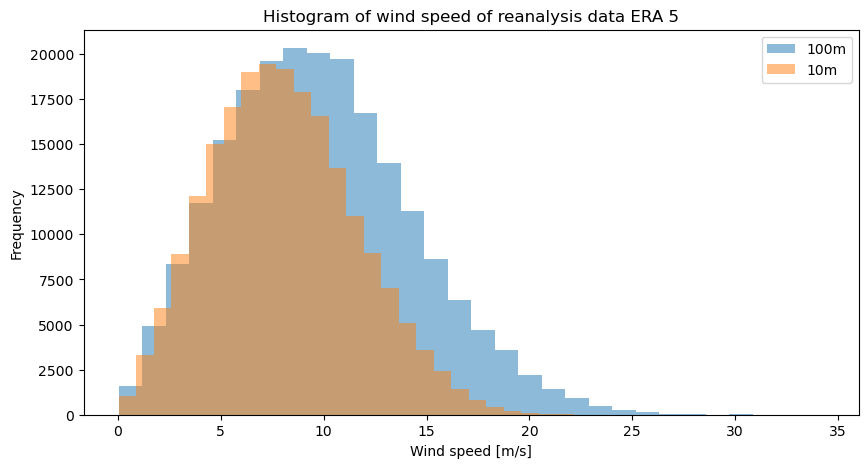

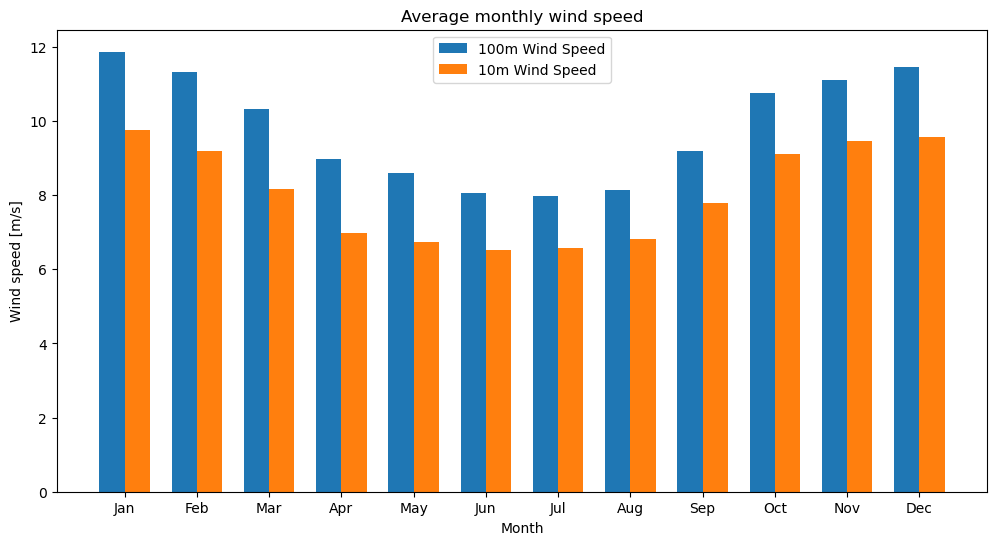

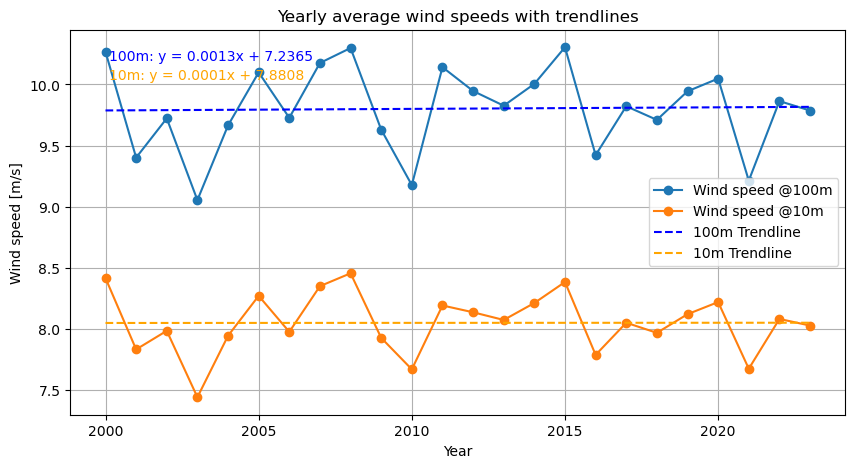


 The Average Wind Speeds over the whole period in m/s:
WS100    9.802337
WS10     8.051765
dtype: float64


In [3]:
# Function to load data from CSV files within the specified date range
def load_era5_data(path, start_year, end_year):
    all_files = [f for f in os.listdir(path) if f.startswith('ERA5_N-9_') and f.endswith('.csv')]
    all_files.sort()
    Era5_data_list = []
    for file in all_files:
        year = int(file.split('_')[-1].split('.')[0])
        if start_year <= year <= end_year:
            Era5_data = pd.read_csv(os.path.join(path, file))
            Era5_data_list.append(Era5_data)
    return pd.concat(Era5_data_list, ignore_index=True)

# Function to calculate wind speed 
def calculate_wind_speed(Era5_data):
    Era5_data['WS100'] = np.sqrt(Era5_data['u100']**2 + Era5_data['v100']**2)
    Era5_data['WS10'] = np.sqrt(Era5_data['u10']**2 + Era5_data['v10']**2)
  
    return Era5_data

# Function to calculate wind direction
def calculate_wind_direction(Era5_data):
    Era5_data['WD100'] = (np.arctan2(Era5_data['u100'], Era5_data['v100']) * 180 / np.pi + 180) % 360 ## need to check with other
    Era5_data['WD10'] = (np.arctan2(Era5_data['u10'], Era5_data['v10']) * 180 / np.pi + 180) % 360
   
    return Era5_data

# Function to calculate yearly and monthly averages
def calculate_averages(Era5_data):
    Era5_data['time'] = pd.to_datetime(Era5_data['Time [UTC]'])
    Era5_data['year'] = Era5_data['time'].dt.year
    Era5_data['month'] = Era5_data['time'].dt.month
    
    yearly_avg = Era5_data.groupby('year')[['WS100', 'WS10']].mean()
    monthly_avg = Era5_data.groupby('month')[['WS100', 'WS10']].mean()
    overall_avg = Era5_data[['WS100', 'WS10']].mean()

    return yearly_avg, monthly_avg, overall_avg

# Function to check for data gaps
#def check_data_gaps(Era5_data):
    Era5_data['time_diff'] = Era5_data['time'].diff()
    gaps = Era5_data[Era5_data['time_diff'] > pd.Timedelta(hours=1)]
    return gaps

def check_data_gaps(Era5_data):
    Era5_data['time'] = pd.to_datetime(Era5_data['Time [UTC]'])
    Era5_data.set_index('time', inplace=True)
    
    # Generate a complete time range based on the data frequency
    full_time_range = pd.date_range(start=Era5_data.index.min(), end=Era5_data.index.max(), freq='H')
    Era5_data = Era5_data.reindex(full_time_range)
    
    missing_data = Era5_data[Era5_data.isnull().any(axis=1)]
    
    total_expected = len(full_time_range)
    total_actual = len(Era5_data.dropna())
    availability = (total_actual / total_expected) * 100
    
    print(f'Data Availability is {availability:.2f}%')
    
    if not missing_data.empty:
        print('Missing time periods are:')
        print(missing_data.index)
    else:
        print('No data gaps are found.')
    
    return missing_data

# Function to plot histograms
def plot_histogram(Era5_data):
    plt.figure(figsize=(10, 5))
    plt.hist(Era5_data['WS100'], bins=30, alpha=0.5, label='100m')
    plt.hist(Era5_data['WS10'], bins=30, alpha=0.5, label='10m')
    plt.xlabel('Wind speed [m/s]')
    plt.ylabel('Frequency')
    plt.title('Histogram of wind speed of reanalysis data ERA 5')
    plt.legend()
    plt.show()

def plot_wind_rose(Era5_data):
    ax = WindroseAxes.from_ax()
    ax.bar(Era5_data['WD100'], Era5_data['WS100'], normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    plt.show()

# Function to plot yearly average wind speed with trendline
def plot_yearly_average_with_trendline(yearly_avg):
    years = yearly_avg.index
    WS100_year = yearly_avg['WS100']
    WS10_year = yearly_avg['WS10']
    
    # Calculate the trendline for 100m wind speed
    z_100m = np.polyfit(years, WS100_year, 1)
    p_100m = np.poly1d(z_100m)
    
    # Calculate the trendline for 10m wind speed
    z_10m = np.polyfit(years, WS10_year, 1)
    p_10m = np.poly1d(z_10m)
    
    plt.figure(figsize=(10, 5))
    
    # Plot the yearly average wind speeds
    plt.plot(years, WS100_year, marker='o', label='Wind speed @100m')
    plt.plot(years, WS10_year, marker='o', label='Wind speed @10m')
    
    # Plot the trendlines
    plt.plot(years, p_100m(years), linestyle='--', label='100m Trendline', color='blue')
    plt.plot(years, p_10m(years), linestyle='--', label='10m Trendline', color='orange')
    
    # Add trendline equations to the plot
    eq_100m = f'100m: y = {z_100m[0]:.4f}x + {z_100m[1]:.4f}'
    eq_10m = f'10m: y = {z_10m[0]:.4f}x + {z_10m[1]:.4f}'
    plt.text(0.05, 0.95, eq_100m, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', color='blue')
    plt.text(0.05, 0.90, eq_10m, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', color='orange')
    
    plt.xlabel('Year')
    plt.ylabel('Wind speed [m/s]')
    plt.title('Yearly average wind speeds with trendlines')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_monthly_average(monthly_avg):
    fig, ax = plt.subplots(figsize=(12, 6))

    months = monthly_avg.index
    WS100 = monthly_avg['WS100']
    WS10 = monthly_avg['WS10']

    width = 0.35  

    ax.bar(months - width/2, WS100, width, label='100m Wind Speed')
    ax.bar(months + width/2, WS10, width, label='10m Wind Speed')

    ax.set_xlabel('Month')
    ax.set_ylabel('Wind speed [m/s]')
    ax.set_title('Average monthly wind speed')
    ax.set_xticks(months)
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.legend()

    plt.show()

## Execution
start_year = 2000
end_year = 2023
    
Era5_data = load_era5_data(era5_path, start_year, end_year)
Era5_data = calculate_wind_speed(Era5_data)
Era5_data = calculate_wind_direction(Era5_data)
    
yearly_avg, monthly_avg, overall_avg = calculate_averages(Era5_data)
missing_data = check_data_gaps(Era5_data)   


plot_histogram(Era5_data)
#plot_wind_rose(Era5_data)

plot_monthly_average(monthly_avg)
plot_yearly_average_with_trendline(yearly_avg)

print('\n The Average Wind Speeds over the whole period in m/s:')
print(overall_avg)


### Load measurement data for MCP

- Buoy2 measurement period: 
2022-03-03 00:00:00 UTC to 2023-06-15 23:50:00 UTC
- Buoy6 measurement period: 
2022-03-03 00:00:00 UTC to 2023-04-04 04:30:00 UTC

In [4]:
#Load the datafiles in xr and netcdf 

xrbuoy6 = xr.open_dataset(bouy6_path)
xrbuoy2 = xr.open_dataset(bouy2_path)

buoy2_file = Dataset(bouy2_path)
buoy6_file = Dataset(bouy6_path)

# load measurement data
time2 = xrbuoy2.variables['time'][:]
windspeed2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_speed'][:]
winddirection_buoy_2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_from_direction'][:]

time6 = xrbuoy6.variables['time'][:]
windspeed6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_speed'][:]
winddirection_buoy_6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_from_direction'][:]


### Process the measurement data and compare with ERA 5 data

The period of merged data(Buoy2 & ERA 5) is: 2000-01-01 00:00:00 to 2023-12-31 23:00:00
The period of merged data(Buoy6 & ERA 5) is: 2000-01-01 00:00:00 to 2023-12-31 23:00:00

<Plotting data for Buoy2>


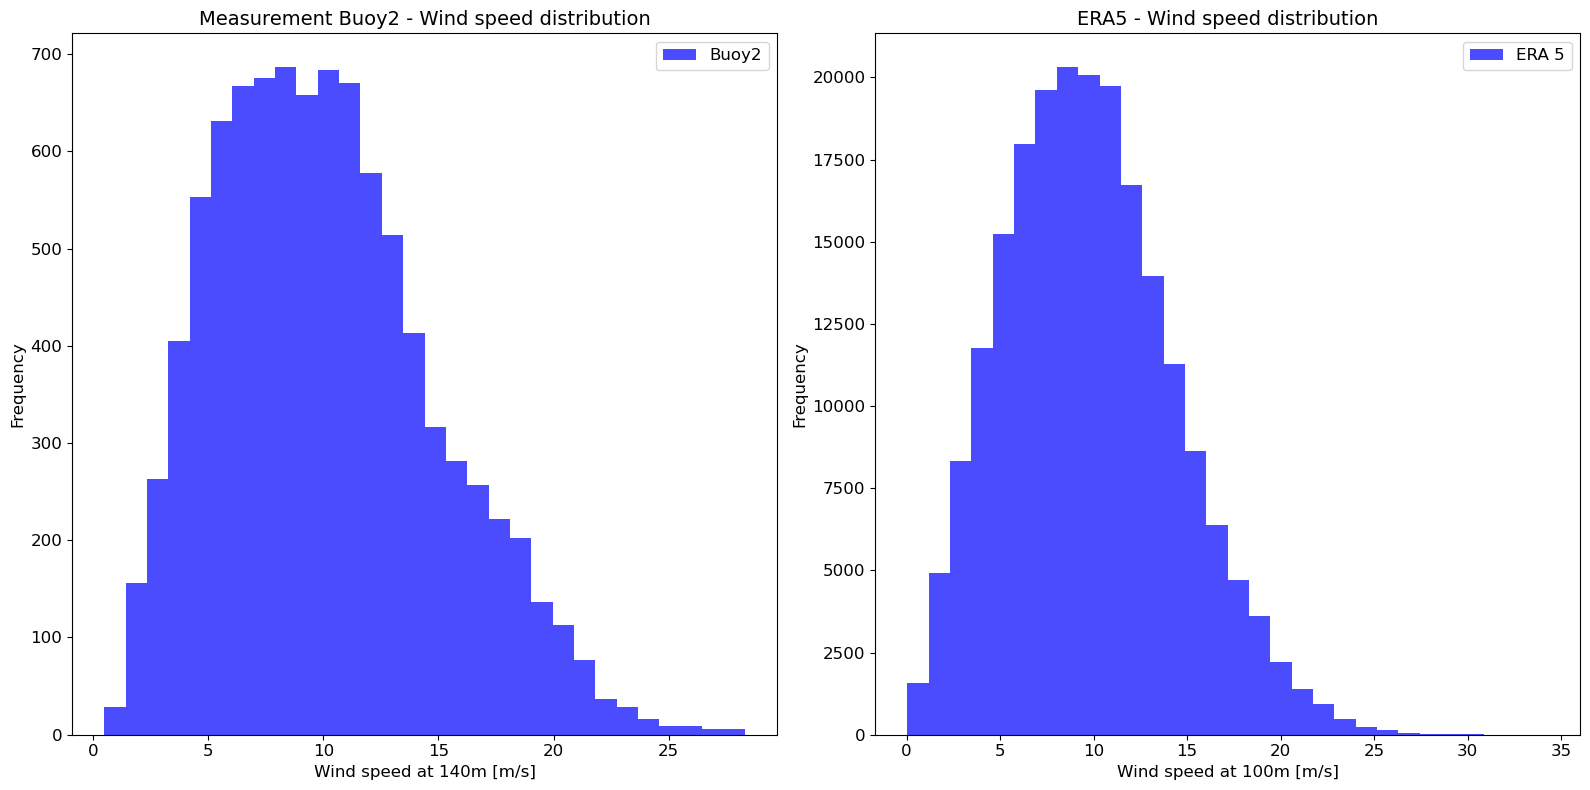

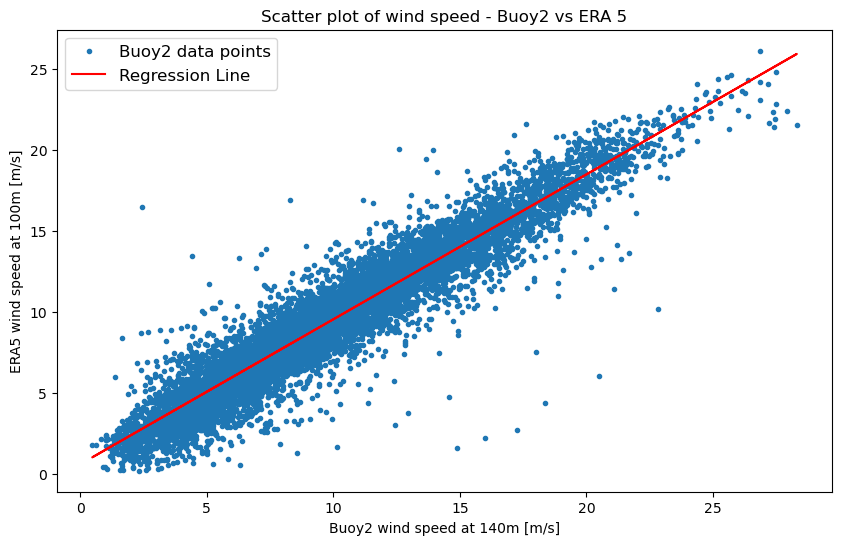


<Statistics for Buoy2>
Correlation coefficient between the measurment and Era5 wind speed: 0.896
Mean wind speed of the measurement at 140m: 10.121 m/s
Mean wind speed of Era 5 data at 100m: 9.669 m/s


<Plotting data for Buoy6>


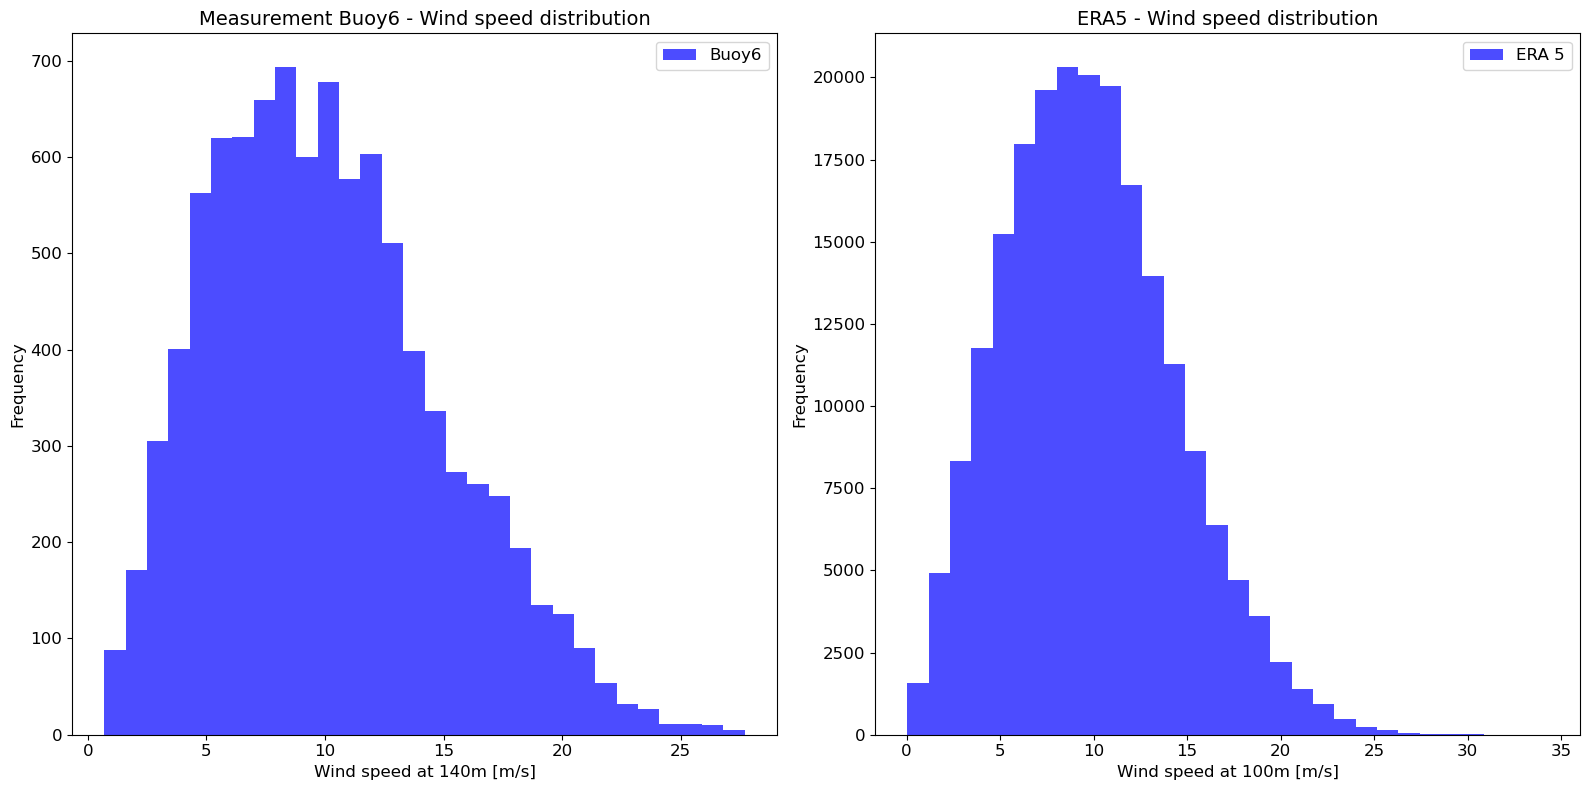

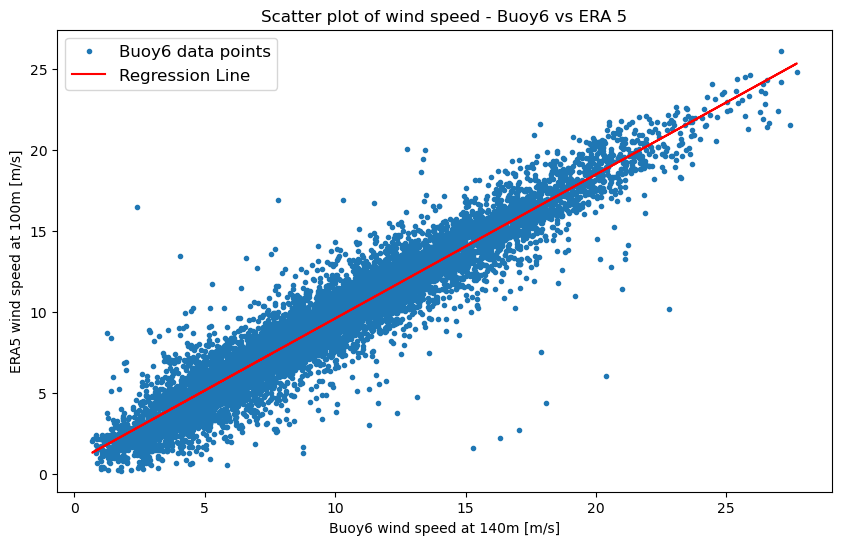


<Statistics for Buoy6>
Correlation coefficient between the measurment and Era5 wind speed: 0.905
Mean wind speed of the measurement at 140m: 10.060 m/s
Mean wind speed of Era 5 data at 100m: 9.667 m/s



In [6]:
def create_buoy_dataframe(time, windspeed, winddirection):
    # Convert time variables to pandas datetime (though it's already in datetime64[ns] format)
    time = pd.to_datetime(time, unit='ns', origin='unix')
    
    # Create a single DataFrame for the buoy with measurements at 140m 
    df_buoy = pd.DataFrame({
        'time': time,
        'meas_WS140': windspeed,
        'meas_WD140': winddirection,
    })
    
    return df_buoy

# Function to clean and resample the measurement data
def process_meas_data(df_buoy):
    
    df_buoy['time'] = pd.to_datetime(df_buoy['time'])  # Ensure 'time' column is in datetime format
    df_buoy.drop_duplicates(subset='time', inplace=True)
    df_buoy.replace(-999, np.nan, inplace=True) # Replace -999 with NaN

    # Resample the data to hourly frequency
    df_buoy.set_index('time', inplace=True)
    df_buoy = df_buoy.resample('h').mean()
    
    return df_buoy

# Function to align measurement data with Era5 data
def merge_data(df_buoy, df_era5, data_name):
   
    df_aligned = pd.merge(df_buoy, df_era5, how='right', on='time')

    # Calculate data period
    data_start = df_aligned.index.min()
    data_end = df_aligned.index.max()

    print(f'The period of merged data({data_name} & ERA 5) is: {data_start} to {data_end}')
   
    return df_aligned

# Function to calculate mean wind speed and correlation coefficient 
def calculate_statistics(df_aligned, data_name):
    
    valid_data = df_aligned.dropna(subset=['meas_WS140', 'era5_WS100']) #remove NaN values
    results = linregress(valid_data['meas_WS140'], valid_data['era5_WS100'])
    mean_meas_ws = valid_data['meas_WS140'].mean()
    mean_era5_ws = valid_data['era5_WS100'].mean()
    
    print(f'\n<Statistics for {data_name}>')
    print(f'Correlation coefficient between the measurment and Era5 wind speed: {results.rvalue**2:.3f}')
    print(f'Mean wind speed of the measurement at 140m: {mean_meas_ws:.3f} m/s')
    print(f'Mean wind speed of Era 5 data at 100m: {mean_era5_ws:.3f} m/s')
    print()
    

def plot_meas_era5_comparison(df_aligned, data_name):
    
    print(f'\n<Plotting data for {data_name}>')
    fig = plt.figure(figsize=(16, 8))
    
    # Histogram of measurement data
    ax1 = fig.add_subplot(121)
    ax1.hist(df_aligned['meas_WS140'].dropna(), bins=30, alpha=0.7, label=f'{data_name}', color='blue')
    #ax1.hist(df_aligned['meas_WS140'].ffill(), bins=30, alpha=0.7, label=f'{data_name}', color='blue')
    ax1.set_title(f'Measurement {data_name} - Wind speed distribution', fontsize=14)
    ax1.set_xlabel('Wind speed at 140m [m/s]', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    
    # Histogram of ERA5 data
    ax2 = fig.add_subplot(122)
    ax2.hist(df_aligned['era5_WS100'].dropna(), bins=30, alpha=0.7, label='ERA 5', color='blue')
    ax2.set_title('ERA5 - Wind speed distribution', fontsize=14)
    ax2.set_xlabel('Wind speed at 100m [m/s]', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Scatter plot with linear regression line
    plt.figure(figsize=(10, 6))
    plt.plot(df_aligned['meas_WS140'], df_aligned['era5_WS100'], '.', label=f'{data_name} data points')
    plt.xlabel(f'{data_name} wind speed at 140m [m/s]')
    plt.ylabel('ERA5 wind speed at 100m [m/s]')
    plt.title(f'Scatter plot of wind speed - {data_name} vs ERA 5')
    
    # Linear regression line
    valid_data = df_aligned.dropna(subset=['meas_WS140', 'era5_WS100'])
    X = valid_data['meas_WS140'].values.reshape(-1, 1)
    y = valid_data['era5_WS100'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    plt.plot(valid_data['meas_WS140'], y_pred, color='red', label='Regression Line')
    plt.legend(fontsize=12)
    
    plt.show()


## Execution

# Create dataframes for buoy 2 and buoy 6
df_buoy2 = create_buoy_dataframe(time2, windspeed2[:, 0, 0, 3], winddirection_buoy_2[:, 0, 0, 3])
df_buoy6 = create_buoy_dataframe(time6, windspeed6[:, 0, 0, 3], winddirection_buoy_6[:, 0, 0, 3])

# Process the measurement data
df_buoy2_processed = process_meas_data(df_buoy2)
df_buoy6_processed = process_meas_data(df_buoy6)

# select desired columns of ERA 5 data
era5_selected = Era5_data[['WS100', 'WD100']].copy()
era5_selected.rename(columns={'WS100': 'era5_WS100', 'WD100': 'era5_WD100'}, inplace=True)

# Merge measurement data with Era5 data
aligned_data_buoy2 = merge_data(df_buoy2_processed, era5_selected,'Buoy2' )
aligned_data_buoy6 = merge_data(df_buoy6_processed, era5_selected,'Buoy6')

# Plot results and print mean wind speed over the whole period and correlation coefficient
plot_meas_era5_comparison(aligned_data_buoy2, 'Buoy2')
calculate_statistics(aligned_data_buoy2, 'Buoy2')

plot_meas_era5_comparison(aligned_data_buoy6, 'Buoy6')
calculate_statistics(aligned_data_buoy6, 'Buoy6')


### MCP Analysis using Linear Regression

In [ ]:
# Function to prepare data for MCP (separating features and target & handling missing values)
def prepare_data_for_MCP(df_aligned):
   
    X = pd.DataFrame(df_aligned['era5_WS100']) #Reanalysis data
    Y = pd.DataFrame(df_aligned['meas_WS140'].copy()) #Measurement

    # Remove NaN values
    idx = Y[Y.isnull().any(axis=1)].index
    valid_values = Y[Y.notnull().all(axis=1)].index

    XtoPredict = X.loc[idx]
    x = X.loc[valid_values] #Features
    y = Y.loc[valid_values] #Target

    return x, y

# Function to perform MCP using linear regression
def perform_linear_mcp(X_train, y_train, X_test):
    
    lin_model = LinearRegression() #sklearn.linear_model
    lin_model.fit(X_train, y_train)
    y_pred = lin_model.predict(X_test)

    return lin_model, y_pred

# Function to evaluate the mcp model by comparing test targets and predicted values
def evaluate_mcp_model(y_test, y_pred, data_name):
   
    mae = mean_absolute_error(y_test, y_pred) # Mean absolute error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Root mean squared error
    results = linregress(y_test.values.flatten(), y_pred.flatten()) # Flatten to 1D array, then linregress
    correlation = results.rvalue**2
   
    print(f'<Evaluation of MCP model for {data_name}>')
    print(f'Mean absolute error: {mae:.3f}')
    print(f'Root mean squared error: {rmse:.3f}')
    print(f'Correlation coefficient: {results.rvalue**2:.3f}')

    # Scatter plot with linear regression line
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, y_pred, '.', label='Data points')
    plt.xlabel(f'Test - Measured wind speed of {data_name} [m/s]')
    plt.ylabel(f'Test - Predicted wind speed of {data_name} [m/s]')
    plt.title(f'Scatter plot of wind speed - Predicted {data_name} test data vs Actual {data_name} test data')
    reg = LinearRegression().fit(y_test,  y_pred)
    plt.plot(y_test, reg.predict(y_test), color='red', label='Regression Line')
       
    plt.legend()
    plt.show()

    return mae, rmse, correlation


def calculate_mean_wind_speed(predicted_df, orig_meas, corr_meas, data_name):
    
    mean_wind_speed_orig = predicted_df[orig_meas].mean()
    mean_wind_speed_corr = predicted_df[corr_meas].mean()

    print(f'\n<Mean wind speeds for {data_name}>')
    print(f'Mean wind speed of the original measurement: {mean_wind_speed_orig:.3f} m/s')
    print(f'Mean wind speed of the long-term corrected measurement: {mean_wind_speed_corr:.3f} m/s')

    return mean_wind_speed_orig, mean_wind_speed_corr

def plot_linear_mcp_results(predicted_df, orig_meas, corr_meas, data_name):
   
    print(f'\n<Plotting data for {data_name}>')
    # Plot the original measurement wind distribution and predicted wind distribution
    plt.figure(figsize=(12, 6))

    # Plot original measurement wind distribution
    plt.subplot(1, 2, 1)
    plt.hist(predicted_df['meas_WS140'].dropna(), bins=30, alpha=0.7, label='Original measurement')
    plt.xlabel('Wind speed [m/s]')
    plt.ylabel('Frequency')
    plt.title(f'Short-term measured wind distribution of {data_name}')
    plt.legend()

    # Plot predicted wind distribution
    plt.subplot(1, 2, 2)
    plt.hist(predicted_df['predicted_WS140'], bins=30, alpha=0.7, label='Predicted measurement')
    plt.xlabel('Wind speed [m/s]')
    plt.ylabel('Frequency')
    plt.title(f'Long-term predicted wind distribution of {data_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    # Calculate and plot monthly average wind speed
    predicted_df['month'] = predicted_df.index.month
    monthly_avg_meas = predicted_df.groupby('month')[orig_meas].mean()
    monthly_avg_corr = predicted_df.groupby('month')[corr_meas].mean()
    months = monthly_avg_meas.index
    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.35  

    ax.bar(months - bar_width/2, monthly_avg_meas, bar_width, label='Measured wind speed')
    ax.bar(months + bar_width/2, monthly_avg_corr, bar_width, label='Corrected wind speed')

    ax.set_xlabel('Month')
    ax.set_ylabel('Wind speed [m/s]')
    ax.set_title(f'Comparison of average monthly wind speed of {data_name} - Original vs Long-term corrected')
    ax.set_xticks(months)
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.legend()

    plt.show()

    plt.plot(monthly_avg_meas.index, monthly_avg_meas, label='Measured wind speed', marker='o')
    plt.plot(monthly_avg_corr.index, monthly_avg_corr, label='Corrected wind speed', marker='o')
    plt.xlabel('Month')
    plt.ylabel('Average wind speed [m/s]')
    plt.title(f'Comparison of average monthly wind speed of {data_name} - Original vs Long-term corrected')
    plt.legend()
    plt.grid(True)
    plt.show()


def run_lin_mcp_workflow(df_aligned, data_name):
    
    # Prepare the data
    x, y = prepare_data_for_MCP(df_aligned)

    # Split data into training and test data
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)  # test size 30%

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Perform MCP for test data
    lin_model, y_pred = perform_linear_mcp(X_train_scaled, y_train, X_test_scaled)

    # Evaluate the model
    mae, rmse, correlation = evaluate_mcp_model(y_test, y_pred, data_name)

    # Predict on the full dataset (using the scaled data)
    df_aligned['predicted_WS140'] = lin_model.predict(scaler.transform(pd.DataFrame(df_aligned[['era5_WS100']])))

    # Calculate and print mean wind speeds
    mean_meas_ws, mean_pred_ws = calculate_mean_wind_speed(df_aligned,'meas_WS140', 'predicted_WS140', data_name)

    # Plot the results
    plot_linear_mcp_results(df_aligned, 'meas_WS140', 'predicted_WS140', data_name)


# Execution
run_lin_mcp_workflow(aligned_data_buoy2, 'Buoy2')
run_lin_mcp_workflow(aligned_data_buoy6, 'Buoy6')


In [ ]:
print(aligned_data_buoy2)

                     meas_WS140  meas_WD140  era5_WS100  era5_WD100  \
time                                                                  
2000-01-01 00:00:00         NaN         NaN   11.917305  217.780529   
2000-01-01 01:00:00         NaN         NaN   12.603063  222.948625   
2000-01-01 02:00:00         NaN         NaN   12.925649  230.383424   
2000-01-01 03:00:00         NaN         NaN   12.376868  232.134761   
2000-01-01 04:00:00         NaN         NaN   12.502682  237.078915   
...                         ...         ...         ...         ...   
2023-12-31 19:00:00         NaN         NaN   17.195736  183.073556   
2023-12-31 20:00:00         NaN         NaN   16.940771  188.400824   
2023-12-31 21:00:00         NaN         NaN   16.445522  191.365960   
2023-12-31 22:00:00         NaN         NaN   15.909499  194.710568   
2023-12-31 23:00:00         NaN         NaN   14.978932  202.557192   

                     predicted_WS140  month  
time                          

In [ ]:
## Back up Execution

# Prepare the data
x, y = prepare_data_for_MCP(aligned_data_buoy2)

# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42) #test size 30%

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform MCP for test data
lin_model, y_pred = perform_linear_mcp(X_train_scaled, y_train, X_test_scaled)

# Evaluate the model
mae, rmse, correlation = evaluate_mcp_model(y_test, y_pred, 'Buoy2')

# Predict on the full dataset (using the scaled data)
aligned_data_buoy2['predicted_WS140'] = lin_model.predict(scaler.transform(pd.DataFrame(aligned_data_buoy2[['era5_WS100']])))

# Calculate and print mean wind speeds
mean_meas_ws, mean_pred_ws = calculate_mean_wind_speed(aligned_data_buoy2, 'meas_WS140','predicted_WS140', 'Buoy2')

# Plot the results
plot_linear_mcp_results(aligned_data_buoy2,'meas_WS140', 'predicted_WS140', 'Buoy2')